In [1]:
from tscode.utils import read_xyz, graphize, scramble_check, write_xyz
import os

os.chdir('/mnt/c/Users/Nick/Desktop/winscp_temp')

mol1 = read_xyz('MsNO2.xyz')
mol2 = read_xyz('propip.xyz')
mol3 = read_xyz('maybe_scrambled.xyz')
print(len(mol1.atomcoords[0]), len(mol2.atomcoords[0]),len(mol3.atomcoords[0]))

38 116 154


In [2]:
graph1 = graphize(mol1.atomcoords[0], mol1.atomnos)
graph2 = graphize(mol2.atomcoords[0], mol2.atomnos)
graph3 = graphize(mol3.atomcoords[0], mol3.atomnos)
print(len(graph1.nodes), len(graph2.nodes),len(graph3.nodes))

38 116 154


In [3]:
import numpy as np

In [4]:
mols_graphs = [graph1, graph2]
constrained_indices = np.array([
    [4, 35],
    [36, 153], [37, 149]])
excluded_atoms = constrained_indices.ravel()
excluded_atoms

array([  4,  35,  36, 153,  37, 149])

In [5]:
from tscode.calculators._xtb import xtb_opt
opt_coords, energy, success = xtb_opt(
                mol3.atomcoords[0],
                # opt_coords,
                mol3.atomnos,
                # constrained_indices=constrained_indices,
                # constrained_distances=[None, 1.6, 1.6],
                constrained_indices=[constrained_indices[0]],
                constrained_distances=[None,],
                method='GFN2-XTB')
success

True

In [6]:
energy

-162656.01207416796

In [7]:
bonds = set()
for i, graph in enumerate(mols_graphs):

    # pos = 0
    # while i != 0:
    #     pos += len(mols_graphs[i-1].nodes)
    #     i -= 1
    pos = sum([len(other_graph.nodes) for j, other_graph in enumerate(mols_graphs) if j < i])

    for bond in [tuple(sorted((a+pos, b+pos))) for a, b in list(graph.edges) if a != b]:
        bonds.add(bond)
# creating bond set containing all bonds present in the desired transition state

new_bonds = {tuple(sorted((a, b))) for a, b in list(graphize(opt_coords, mol3.atomnos).edges) if a != b}
delta_bonds = (bonds | new_bonds) - (bonds & new_bonds)
# delta_bonds -= {tuple(sorted(pair)) for pair in constrained_indices}

for bond in delta_bonds.copy():
    for a in excluded_atoms:
        if a in bond:
            delta_bonds -= {bond}
# removing bonds involving constrained atoms: they are not counted as scrambled bonds


In [8]:
delta_bonds

set()

In [9]:
with open('optimized.xyz', 'w') as _f:
    write_xyz(opt_coords, mol3.atomnos, _f)

In [3]:
with open('force_field_refining_tight_constraints.dat', 'r') as f:
    data = f.read()

In [4]:
lines = [line.split(' : ')[1] for line in data.replace('\n [', ', [').split('\n') if len(line.split(' : ')) > 1]

In [5]:
lines = [line.replace('[','').replace(',', '').replace(']','').split() for line in lines]

In [6]:
lines = [[int(n) for n in line] for line in lines]

In [7]:
ens_constr = np.array([[[l[0], l[1]], [l[2], l[3]]] for l in lines])
ens_constr[0]

array([[ 36, 153],
       [ 37, 149]])

In [8]:
ens_structs = read_xyz('force_field_refining_tight_structures.xyz')
print(len(ens_structs.atomcoords), len(ens_constr))

3073 3073


(array([521., 287., 434., 393., 256., 189., 360., 321., 241.,  71.]),
 array([-0.13143273,  1.72435417,  3.58014108,  5.43592798,  7.29171489,
         9.14750179, 11.0032887 , 12.8590756 , 14.71486251, 16.57064941,
        18.42643632]),
 <BarContainer object of 10 artists>)

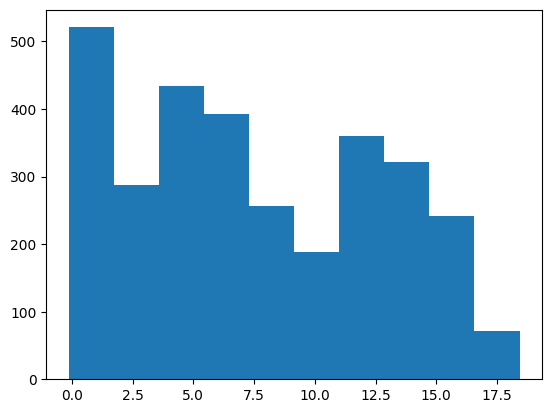

In [11]:
from tscode.utils import norm_of
import matplotlib.pyplot as plt
errors = []
for constraint, structure in zip(ens_constr, ens_structs.atomcoords):
    (a, b), (c, d) = constraint
    d1 = norm_of(
        structure[a]-
        structure[b]
    ) - 1.6
    d2 = norm_of(
        structure[c]-
        structure[d]
    ) - 1.6
    errors.append(d1+d2)
plt.hist(errors)

## LOADING EMBEDDER

In [4]:
os.chdir('multiembed_test')

In [9]:
import pickle

with open('force_field_refining_tight_runembedding.pickle', 'rb') as f:
    d = pickle.load(f)

In [10]:
len(d['energies'])

7131

In [8]:
d['energies'][0] = 1E10
d['energies'][1] = 1E10
d['energies'][2] = 1E10
# (d['energies']-np.min(d['energies']))[1:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
d['energies']